# Presto differential expression glmm

In [2]:
suppressPackageStartupMessages({
    library(Seurat)
    library(dplyr)
    library(data.table)
    library(ggplot2)
    library(patchwork)
    library(harmony)
    library(entropy)
    library(presto)
    library(singlecellmethods)
    library(lme4)
    library(purrr)
    library(pheatmap)
    library(rcna)
    library(glue)
    library(ggthemes)
})

source("myfun.r")

In [101]:
merged <- readRDS("/data/brennerlab/Shani/projects/Treg/analysis/integrated/integrated.Tregs.rds")

In [102]:
merged

An object of class Seurat 
38406 features across 18909 samples within 3 assays 
Active assay: RNA (38224 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 other assays present: ADT, HTO
 3 dimensional reductions calculated: pca, harmony, humap

In [94]:
# merged$cell.states <- factor(merged$cell.states, levels = c('Naive Treg - TCF7/CCR7',
#                                                             'CD25-intermediate Treg',
#                                                             'CD25-high Treg',
#                                                             'CD25-high CXCR6+ Treg',
#                                                             'AREG Treg',
#                                                             'TNFa response Treg',
#                                                             'CD161+ memory Treg',
#                                                             'ISG high Treg',
#                                                             'GZM+ Treg',
#                                                             'Proliferating'))


In [103]:
# collapsing donor and dataset into one variable
# merged@meta.data <- merged@meta.data%>% tidyr::unite("donor.dataset", c(donorID, orig.ident), remove = F)
data.collapsed <- collapse_counts(merged@assays$RNA@counts,
                                  merged@meta.data,
                                  c("cell.states", "donorID", "orig.ident", "tissue"))

CAREFUL: get_norm makes very strong assumptions about data



In [104]:
dim(data.collapsed$counts_mat)

[1] 38224   749

In [105]:
rnames <- rownames(data.collapsed$counts_mat)
data.collapsed$counts_mat <- apply(data.collapsed$counts_mat, 2, function(x) as.integer(as.character(x)))
rownames(data.collapsed$counts_mat) <- rnames                                  
                                   
data.collapsed$counts_mat%>% head

,sample_10525,sample_10522,sample_10527,sample_10524,sample_10520,sample_10526,sample_10523,sample_10521,sample_10529,sample_10374,⋯,sample_2505,sample_2501,sample_2503,sample_2504,sample_2500,sample_2502,sample_2506,sample_2508,sample_2507,sample_2509
MIR1302-2HG,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
FAM138A,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
OR4F5,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
AL627309.1,0,0,0,0,0,0,0,0,0,0,⋯,0,1,0,1,1,0,0,0,0,0
AL627309.3,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
AL627309.2,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [91]:
# data.collapsed$meta_data <- data.collapsed$meta_data %>% tidyr::unite("sample.name", c(donorID, orig.ident, tissue), remove = F)
# data.collapsed$meta_data %>% head
# dim(data.collapsed$counts_mat)

In [106]:
#filter for rows with >0 counts in total
data.collapsed$counts_mat <- data.collapsed$counts_mat[rowSums(data.collapsed$counts_mat) > 0,]
dim(data.collapsed$counts_mat)

[1] 26014   749

In [123]:
rerun = T
if (rerun) {
system.time({
    suppressWarnings({
        presto_res1 = presto::presto.presto(
          #  y ~ 1 + orig.ident + tissue + (1|cell.states) + (1|donorID) + (1|cell.states:tissue) + offset(logUMI), 
            # y ~ 1 + (1|orig.ident) + (1|cell.states:tissue) + (1|cell.states) + (1|donorID) + (1|tissue) + offset(logUMI),
            y ~ 1 + (1|orig.ident) + (1|cell.states) + (1|donorID) + (1|tissue) + offset(logUMI),
            # y ~ 1 + (1|sample.name) + (1|cell.states) + (1|cell.states:tissue) + offset(logUMI), 
            # y ~ 1 + (1|cell.states) + offset(logUMI),
            design = data.collapsed$meta_data, 
            response = data.collapsed$counts_mat,
            size_varname = "logUMI", 
            effects_cov = c("cell.states"), #, "cell.states:tissue"),
            # features = c("AREG", "CXCR6", "NR3C1"), 
            ncore = 2, 
            min_sigma = .05,
            family = "poisson",
            nsim = 1000
        )    
    })
})
    }

CAUTION: if using GLMM, make sure your counts are integers!

Joining with `by = join_by(grpvar_orig)`


     user    system   elapsed 
54748.534   254.286 27669.419 

In [275]:
should.save = F
read.existing = T
if (should.save) {
    saveRDS(presto_res1, "/data/brennerlab/Shani/projects/Treg/analysis/integrated/integrated.Tregs.noInteractions.rds")
} else if (read.existing) {
    # presto_res1 <- readRDS("/data/brennerlab/Shani/projects/Treg/analysis/integrated/integrated.Tregs.prestoResults.Full.rds")
    presto_res1 <- readRDS("/data/brennerlab/Shani/projects/Treg/analysis/integrated/integrated.Tregs.prestoResults.noInteractions.rds")
    }

In [325]:
presto_res1$formula_str

[1] "~"                                                                                         
[2] "y"                                                                                         
[3] "1 + (1 | orig.ident) + (1 | cell.states) + (1 | donorID) + (1 | tissue) + offset(EXPOSURE)"

In [326]:
contrasts_mat = make_contrast.presto(
    presto_res1, 
    var_contrast = 'cell.states')

In [327]:
effects <- contrasts.presto(presto_res1, contrasts_mat, one_tailed = F) %>% 
    dplyr::mutate(cluster = contrast) %>% 
    dplyr::mutate(
        logFC = sign(beta) * log2(exp(abs(beta))), ## convert stats to log2 for interpretability 
        SD = log2(exp(sigma)),
        zscore = logFC / SD
    ) %>%
    arrange(pvalue)

effects$fdr = p.adjust(effects$pvalue, method = 'BH')

In [328]:
effects %>% head

contrast,feature,beta,sigma,zscore,pvalue,cluster,logFC,SD,fdr
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
Prolif.,MALAT1,-1.2779594,0.05909776,-21.62450,1.056587e-103,Prolif.,-1.8437056,0.08526004,2.713633e-98
Prolif.,BTG1,-0.9738457,0.04960044,-19.63381,7.952127e-86,Prolif.,-1.4049624,0.07155831,1.021172e-80
ISG Treg,ISG15,1.9302881,0.10236826,18.85631,2.607736e-79,ISG Treg,2.7848171,0.14768618,2.232483e-74
Prolif.,TUBA1B,1.6200053,0.08632070,18.76729,1.398462e-78,Prolif.,2.3371737,0.12453444,8.979176e-74
Prolif.,TXNIP,-1.1999563,0.06452956,-18.59545,3.497628e-77,Prolif.,-1.7311710,0.09309648,1.796592e-72
Prolif.,FTL,-0.6401740,0.03471242,-18.44222,6.021811e-76,Prolif.,-0.9235759,0.05007943,2.577636e-71


In [341]:
#filter genes
pval.thresh <- 0.01
fc.thresh <- 0.5 #log2(1.4)

filtered = effects %>% 
filter(pvalue < pval.thresh & abs(logFC) > fc.thresh) %>% 
group_by(contrast) %>% 
arrange(desc(zscore))%>% ungroup()
filtered %>% head
dim(filtered)


contrast,feature,beta,sigma,zscore,pvalue,cluster,logFC,SD,fdr
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
ISG Treg,ISG15,1.9302881,0.10236826,18.85631,2.607736e-79,ISG Treg,2.784817,0.14768618,2.232483e-74
Prolif.,TUBA1B,1.6200053,0.08632070,18.76729,1.398462e-78,Prolif.,2.337174,0.12453444,8.979176e-74
ISG Treg,MX1,2.0159854,0.11417247,17.65737,8.930769e-70,ISG Treg,2.908452,0.16471606,2.867112e-65
Prolif.,PPIA,0.8357051,0.04806536,17.38685,1.037842e-67,Prolif.,1.205668,0.06934365,2.665489e-63
Prolif.,STMN1,3.0084228,0.17695746,17.00082,8.097279e-65,Prolif.,4.340237,0.25529566,1.599711e-60
ISG Treg,IFI6,1.7939434,0.10585642,16.94695,2.027026e-64,ISG Treg,2.588113,0.15271853,3.718579e-60


[1] 10383    10

In [342]:
round(fc.thresh, 2)

[1] 0.5

In [343]:
filtered %>% filter(feature == 'AREG')


contrast,feature,beta,sigma,zscore,pvalue,cluster,logFC,SD,fdr
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
CD25loAREG+ Treg,AREG,1.3887921,0.1157981,11.993225,3.855934e-33,CD25loAREG+ Treg,2.0036035,0.1670613,3.993224e-30
CD25hiTNFAIP3+ Treg,AREG,0.4253921,0.1150226,3.698336,2.170173e-04,CD25hiTNFAIP3+ Treg,0.6137111,0.1659425,5.271094e-03
Naive Treg,AREG,0.5174944,0.1604337,3.225596,1.257108e-03,Naive Treg,0.7465866,0.2314570,2.349006e-02
CD25hiCXCR6+ Treg,AREG,-0.4970150,0.1562733,-3.180421,1.470612e-03,CD25hiCXCR6+ Treg,-0.7170411,0.2254548,2.683463e-02
ISG Treg,AREG,-0.4333417,0.1093773,-3.961898,7.435639e-05,ISG Treg,-0.6251799,0.1577981,2.081412e-03
Prolif.,AREG,-0.4473187,0.1045536,-4.278366,1.882705e-05,Prolif.,-0.6453445,0.1508390,6.225507e-04
CD25hiCXCR6- Treg,AREG,-0.7731224,0.1508817,-5.124031,2.990712e-07,CD25hiCXCR6- Treg,-1.1153798,0.2176762,1.490597e-05
GZM Treg,AREG,-0.7512916,0.1040920,-7.217576,5.292256e-13,GZM Treg,-1.0838847,0.1501730,6.830202e-11


In [344]:
filtered %>% filter(feature == 'NR3C1')
effects %>% filter(feature == 'NR3C1')

filtered %>% filter(feature == 'CXCR6')


contrast,feature,beta,sigma,zscore,pvalue,cluster,logFC,SD,fdr
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
CD25loAREG+ Treg,NR3C1,0.4603018,0.04225217,10.894158,1.228976e-27,CD25loAREG+ Treg,0.6640751,0.06095699,7.272762e-25
Naive Treg,NR3C1,-0.3560814,0.06477791,-5.496957,3.864006e-08,Naive Treg,-0.5137169,0.09345477,2.303070e-06


contrast,feature,beta,sigma,zscore,pvalue,cluster,logFC,SD,fdr
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
CD25loAREG+ Treg,NR3C1,0.46030181,0.04225217,10.8941583,1.228976e-27,CD25loAREG+ Treg,0.66407514,0.06095699,7.272762e-25
Naive Treg,NR3C1,-0.35608140,0.06477791,-5.4969571,3.864006e-08,Naive Treg,-0.51371688,0.09345477,2.303070e-06
GZM Treg,NR3C1,-0.18739710,0.04041925,-4.6363328,3.546448e-06,GZM Treg,-0.27035687,0.05831265,1.402578e-04
ISG Treg,NR3C1,-0.15898552,0.04167909,-3.8145147,1.364508e-04,ISG Treg,-0.22936762,0.06013022,3.524973e-03
CD25hiTNFAIP3+ Treg,NR3C1,0.15204576,0.04191241,3.6277026,2.859544e-04,CD25hiTNFAIP3+ Treg,0.21935567,0.06046683,6.679551e-03
CD25hiCXCR6- Treg,NR3C1,-0.13799739,0.06004932,-2.2980677,2.155794e-02,CD25hiCXCR6- Treg,-0.19908815,0.08663285,2.282527e-01
CD25hiCXCR6+ Treg,NR3C1,0.10504403,0.06717142,1.5638203,1.178598e-01,CD25hiCXCR6+ Treg,0.15154650,0.09690788,7.250803e-01
CD161+mem. Treg,NR3C1,0.04332904,0.04021486,1.0774385,2.812844e-01,CD161+mem. Treg,0.06251059,0.05801779,9.999986e-01
Prolif.,NR3C1,0.03437023,0.04517078,0.7608953,4.467196e-01,Prolif.,0.04958576,0.06516765,9.999986e-01


contrast,feature,beta,sigma,zscore,pvalue,cluster,logFC,SD,fdr
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
CD25hiCXCR6+ Treg,CXCR6,1.9704832,0.4414351,4.463812,8.051426e-06,CD25hiCXCR6+ Treg,2.842806,0.6368562,2.926476e-04
CD161+mem. Treg,CXCR6,1.2201373,0.2876809,4.241287,2.222416e-05,CD161+mem. Treg,1.760286,0.4150358,7.230593e-04
Prolif.,CXCR6,1.0044060,0.2850674,3.523399,4.260495e-04,Prolif.,1.449052,0.4112653,9.407006e-03
ISG Treg,CXCR6,0.8442467,0.2836403,2.976469,2.915881e-03,ISG Treg,1.217991,0.4092065,4.711158e-02
CD25int Treg,CXCR6,-1.5766921,0.4676007,-3.371877,7.465776e-04,CD25int Treg,-2.274686,0.6746052,1.514083e-02
CD25loAREG+ Treg,CXCR6,-2.0977106,0.5018117,-4.180274,2.911576e-05,CD25loAREG+ Treg,-3.026357,0.7239612,9.141171e-04
Naive Treg,CXCR6,-3.8040769,0.4821103,-7.890470,3.010517e-15,Naive Treg,-5.488123,0.6955382,5.070105e-13


In [345]:
show.top <- filtered %>% 
    filter(zscore > 0) %>% 
    group_by(contrast) %>% 
    arrange(contrast, desc(zscore)) %>% 
    dplyr::select(feature, contrast) %>% 
    mutate(row = row_number()) %>% 
    tidyr::pivot_wider(names_from = contrast, values_from = feature)
show.top[1:65,]

row,CD161+mem. Treg,CD25hiCXCR6+ Treg,CD25hiCXCR6- Treg,CD25hiTNFAIP3+ Treg,CD25int Treg,CD25loAREG+ Treg,GZM Treg,ISG Treg,Naive Treg,Prolif.
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,AQP3,CD7,TRBV9,TNFAIP3,CRIP2,HIST1H4C,GZMK,ISG15,EEF1B2,TUBA1B
2,KLRB1,TNFRSF4,ITM2C,FTH1,IGLV1-40,CITED2,IFNG-AS1,MX1,RPS5,PPIA
3,NOSIP,LAIR2,IL32,ZFP36,FCRL3,NR4A2,ST8SIA1,IFI6,RPS3A,STMN1
4,CYTH1,CTLA4,UTS2,RGCC,PTGER2,ZFP36L2,IGKC,XAF1,RPS13,HMGN2
5,TSHZ2,TIMP1,HPGD,KLF6,CDO1,AREG,LYAR,LY6E,RPS6,HMGB1
6,CMTM6,BATF,HLA-DQA2,DNAJB1,IGKV3-20,CYCS,CCL5,STAT1,RPS12,H2AFZ
7,CTSH,HCST,ITGB1,CREM,IGHV2-5,ZNF331,FOXP1,IRF7,RPS3,RAN
8,GPR183,SPOCK2,MFGE8,DNAJA1,MYC,FOS,ANK3,ISG20,RPL5,GAPDH
9,TRBV28,CD27,SAMHD1,SELENOK,MAL,YPEL5,VAMP2,IFITM1,RPL32,HNRNPA2B1


In [346]:
show.top %>% filter(`CD25hiCXCR6+ Treg` == "CXCR6")

row,CD161+mem. Treg,CD25hiCXCR6+ Treg,CD25hiCXCR6- Treg,CD25hiTNFAIP3+ Treg,CD25int Treg,CD25loAREG+ Treg,GZM Treg,ISG Treg,Naive Treg,Prolif.
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
125,BLMH,CXCR6,SMPD3,RALGAPA1,NA,TRBV23-1,AC078883.1,PI4K2B,LINC00402,CLTA


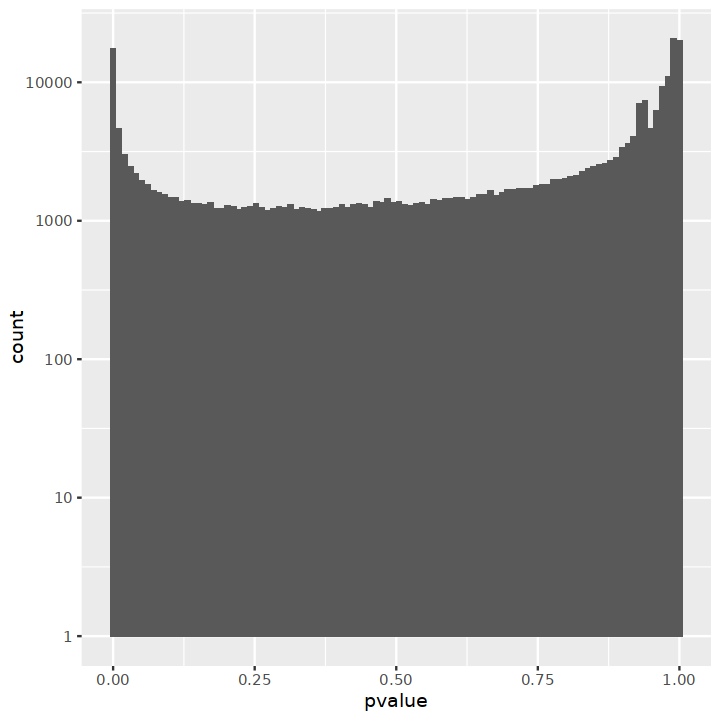

In [347]:
fig.size(6,6)
ggplot(effects, aes(pvalue)) +
geom_histogram(bins = 100) +
scale_y_continuous(trans = 'log10')

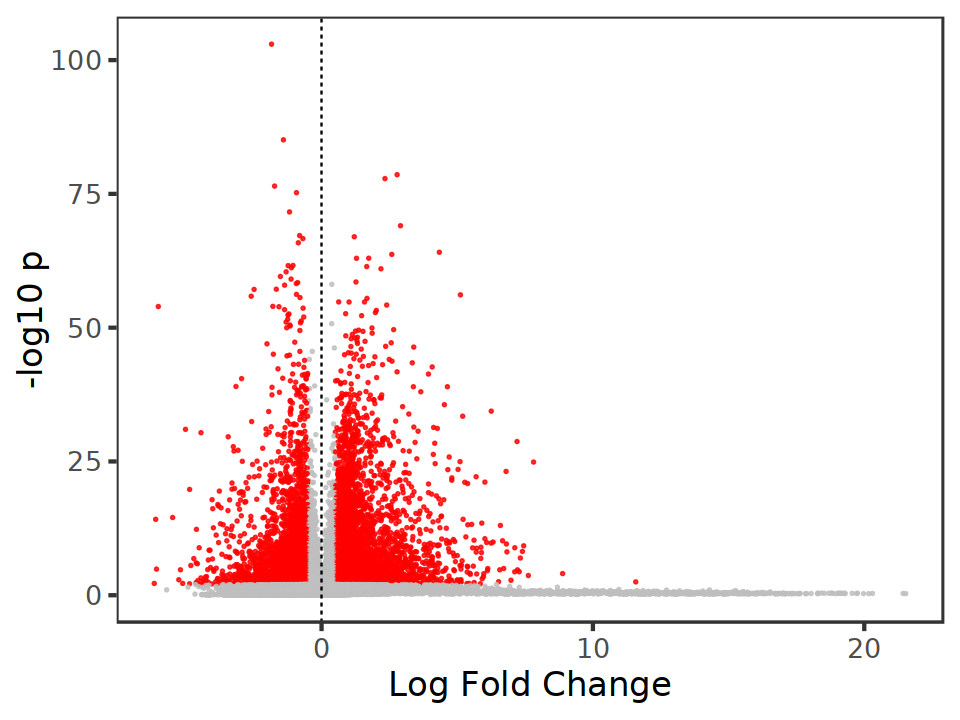

In [348]:
fig.size(6,8)
effects %>% 
        ggplot(aes(logFC, -log10(pvalue), color = pvalue < pval.thresh & abs(logFC) > fc.thresh)) + 
            geom_point(alpha = .8, size = .5) + 
            theme_test(base_size = 20) + 
            geom_vline(xintercept = 0, linetype = 2, color = 'black') + 
            labs(y = '-log10 p', x = 'Log Fold Change') + 
            scale_color_manual(values = c('grey', 'red')) + 
            guides(color = FALSE)

### Save effects

In [349]:
write.csv(effects, "/data/brennerlab/Shani/projects/Treg/analysis/integrated/integrated.Tregs.prestoResults.20250325.effects.csv")
# save gene table
write.csv(filtered, "/data/brennerlab/Shani/projects/Treg/analysis/integrated/integrated.Tregs.prestoResults.20250325.filteredMarkers.csv")
write.csv(show.top, "/data/brennerlab/Shani/projects/Treg/analysis/integrated/integrated.Tregs.prestoResults.20250325.genenames.filteredMarkers.csv")

## Heatmaps

In [52]:
zscore.4hm <- effects %>% select(cluster, feature, zscore) %>% 
                tidyr::pivot_wider(names_from = cluster, values_from = zscore) %>% 
                tibble::column_to_rownames("feature")
zscore.4hm %>% head

,Proliferating,ISG high Treg,GZM+ Treg,TNFa response Treg,CD161+ memory Treg,Naive Treg - TCF7/CCR7,AREG Treg,CD25-high CXCR6+ Treg,CD25-high Treg,CD25-intermediate Treg
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MALAT1,-10.5055758,1.470281,2.01594530,1.7362519,0.58740894,0.9328409,0.7810863,-0.01435527,0.61209485,0.4631124
HMGN2,10.1199613,-1.591347,0.04419043,-1.5339411,-1.68783294,-0.6185275,-0.6389764,-0.36374187,-0.17248797,-0.4731607
MX1,-0.9554493,9.987878,-1.79412507,-0.1452556,-0.48938142,-1.6255478,-0.9081442,0.31512783,0.02090431,-0.6817878
EIF2AK2,-0.7618577,9.812603,-2.40470963,-0.2109799,0.09743178,-1.2269088,-0.9972998,0.12830322,0.20324029,-0.4409361
ISG15,-0.4207062,9.711922,-2.22781333,0.5392511,0.01827105,-2.3189346,-0.6732387,0.51665727,0.12743063,-0.9958972
IFIT1,-0.8427527,9.370604,-1.80625123,-1.0035014,-0.45746768,-0.2834262,-0.1625281,-0.09324521,-0.67000586,-0.4969393


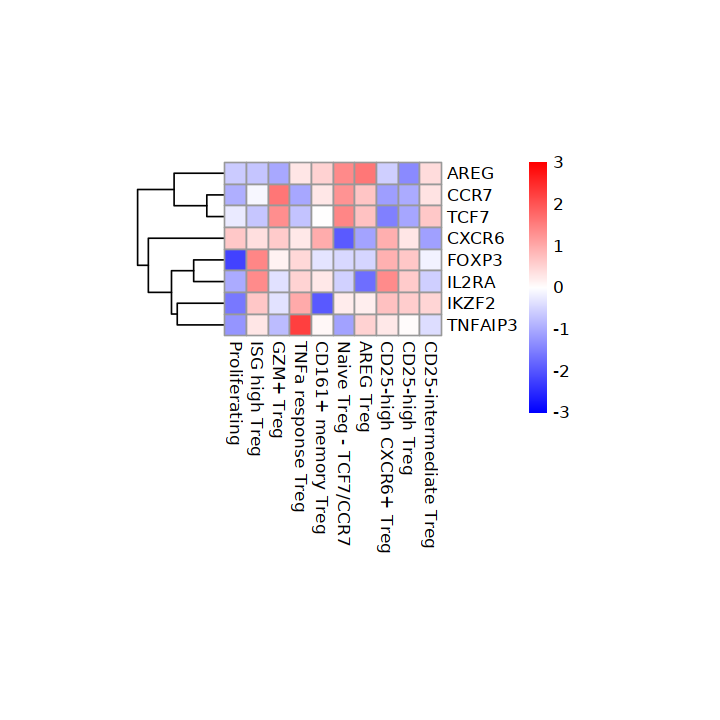

In [53]:
colorBreaks_cor = seq(-3,3,length=1000)
palette_cor <- colorRampPalette(c("blue", "white", "red"))(n = length(colorBreaks_cor))

pheatmap(zscore.4hm[c("FOXP3", "IL2RA", "IKZF2", "AREG", "CXCR6", "TNFAIP3", "CCR7", "TCF7"),], scale = "row", cluster_cols = F, cluster_rows = T, cellheight=13, cellwidth=13, 
         breaks = colorBreaks_cor, color = palette_cor,  show_colnames = T) #, #annotation_col = organize.samples, 
         # gaps_col = seq(2,62, 6))
         # annotation_colors = cell.st

In [40]:
marker_genes_path <- "/data/brennerlab/Shani/projects/Treg/analysis/Heatmaps_markers.csv"
markers <- read.csv(marker_genes_path)

In [55]:
markers.p <- markers %>% tidyr::pivot_longer(cols = colnames(.), names_to = "group", values_to = "gene") %>% 
                filter(gene != "") %>% arrange(group)
markers.p %>% head

group,gene
<chr>,<chr>
C1.Naïve,CCR7
C1.Naïve,TCF7
C1.Naïve,EEF1B2
C1.Naïve,TXNIP
C1.Naïve,RPL32
C1.Naïve,LEF1


In [60]:
cluster.order <- factor(colnames(zscore.4hm), levels = c('Naive Treg - TCF7/CCR7',
                                                            'CD25-intermediate Treg',
                                                            'CD25-high Treg',
                                                            'CD25-high CXCR6+ Treg',
                                                            'AREG Treg',
                                                            'TNFa response Treg',
                                                            'CD161+ memory Treg',
                                                            'ISG high Treg',
                                                            'GZM+ Treg',
                                                            'Proliferating'))

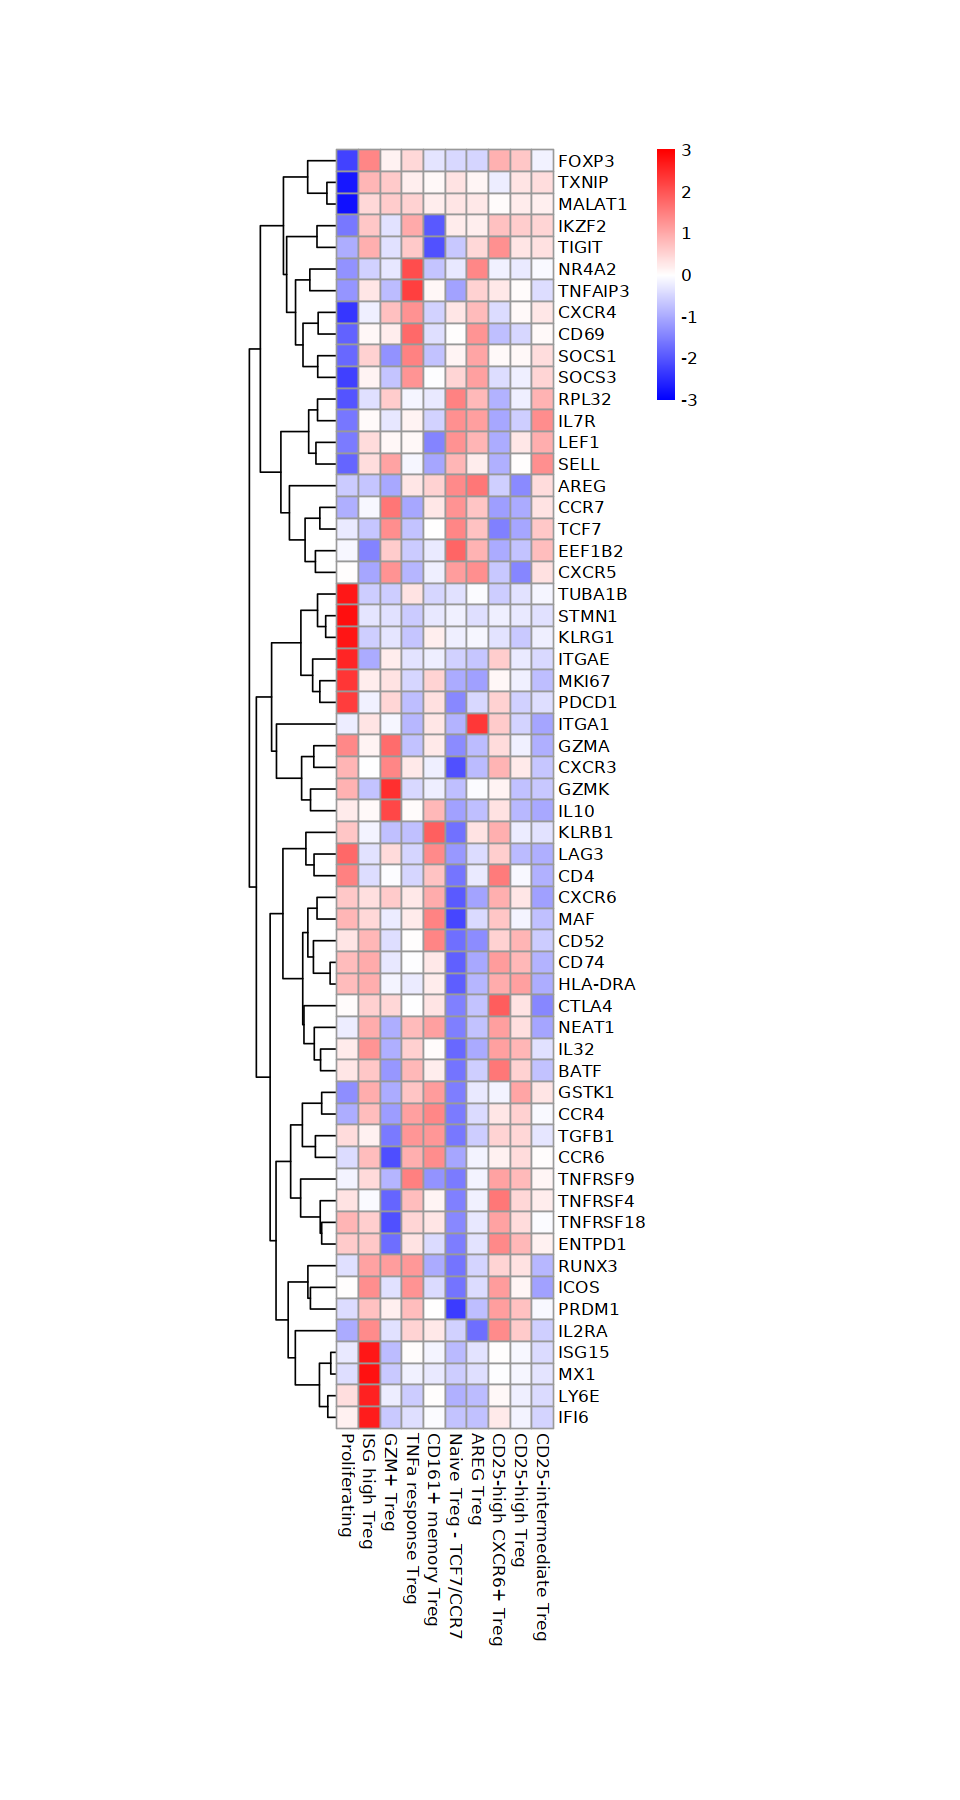

In [61]:
fig.size(15, 8)
pheatmap(zscore.4hm[unique(markers.p$gene),], scale = "row", cluster_cols = F, cluster_rows = T, cellheight=13, cellwidth=13, 
         breaks = colorBreaks_cor, color = palette_cor,  show_colnames = T)

## Evaluate different Presto models

### Simplified - fixed effect representing tissue and dataset together

In [219]:
presto_res1 <- readRDS("/data/brennerlab/Shani/projects/Treg/analysis/integrated/integrated.Tregs.prestoResults.Simplified.rds")


In [220]:
presto_res1$formula_str

[1] "~"                                                                        
[2] "y"                                                                        
[3] "1 + dataset_tissue + (1 | cell.states) + (1 | donorID) + offset(EXPOSURE)"

In [221]:
contrasts_mat = make_contrast.presto(
    presto_res1, 
    var_contrast = 'cell.states')

In [222]:
effects <- contrasts.presto(presto_res1, contrasts_mat, one_tailed = F) %>% 
    dplyr::mutate(cluster = contrast) %>% 
    dplyr::mutate(
        logFC = sign(beta) * log2(exp(abs(beta))), ## convert stats to log2 for interpretability 
        SD = log2(exp(sigma)),
        zscore = logFC / SD
    ) %>%
    arrange(pvalue)

effects$fdr = p.adjust(effects$pvalue, method = 'BH')

In [224]:
#filter genes
pval.thresh <- 0.05
fc.thresh <- log2(1.2)

filtered = effects %>% 
filter(pvalue < pval.thresh & abs(logFC) > fc.thresh) %>% 
group_by(contrast) %>% 
arrange(desc(zscore))%>% ungroup()
filtered %>% head
dim(filtered)


contrast,feature,beta,sigma,zscore,pvalue,cluster,logFC,SD,fdr
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
Proliferating,ACTB,0.9070876,0.005296721,171.2545,0,Proliferating,1.3086508,0.007641554,0
Naive Treg - TCF7/CCR7,RPS12,0.5949692,0.003590436,165.7095,0,Naive Treg - TCF7/CCR7,0.8583591,0.005179904,0
Naive Treg - TCF7/CCR7,RPL32,0.5655576,0.003937987,143.6159,0,Naive Treg - TCF7/CCR7,0.8159271,0.005681314,0
Naive Treg - TCF7/CCR7,MALAT1,0.2625011,0.002053071,127.8578,0,Naive Treg - TCF7/CCR7,0.3787091,0.002961955,0
Proliferating,GAPDH,1.1601633,0.009294399,124.8239,0,Proliferating,1.6737618,0.013408983,0
Naive Treg - TCF7/CCR7,RPL30,0.5031628,0.004106894,122.5166,0,Naive Treg - TCF7/CCR7,0.7259104,0.005924995,0


[1] 30134    10

In [225]:
filtered %>% filter(feature == 'AREG')


contrast,feature,beta,sigma,zscore,pvalue,cluster,logFC,SD,fdr
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
AREG Treg,AREG,1.3875810,0.04978789,27.869853,6.190949e-171,AREG Treg,2.0018563,0.07182874,2.082993e-168
Naive Treg - TCF7/CCR7,AREG,0.5184992,0.06825084,7.596965,3.031568e-14,Naive Treg - TCF7/CCR7,0.7480363,0.09846515,9.716932e-13
TNFa response Treg,AREG,0.4239771,0.05583267,7.593710,3.108729e-14,TNFa response Treg,0.6116697,0.08054952,9.947673e-13
CD25-intermediate Treg,AREG,0.2738606,0.07434815,3.683489,2.300630e-04,CD25-intermediate Treg,0.3950973,0.10726171,2.558830e-03
CD161+ memory Treg,AREG,0.2945312,0.10683811,2.756799,5.837025e-03,CD161+ memory Treg,0.4249187,0.15413481,4.621921e-02
GZM+ Treg,AREG,-0.7439785,0.34599020,-2.150288,3.153247e-02,GZM+ Treg,-1.0733340,0.49915834,1.928716e-01
ISG high Treg,AREG,-0.4339856,0.18200157,-2.384516,1.710163e-02,ISG high Treg,-0.6261088,0.26257277,1.163378e-01
Proliferating,AREG,-0.4486819,0.09716381,-4.617788,3.878529e-06,Proliferating,-0.6473111,0.14017775,5.864418e-05
CD25-high CXCR6+ Treg,AREG,-0.4985598,0.06956343,-7.166981,7.666957e-13,CD25-high CXCR6+ Treg,-0.7192697,0.10035881,2.241148e-11


In [226]:
filtered %>% filter(feature == 'NR3C1')

filtered %>% filter(feature == 'CXCR6')


contrast,feature,beta,sigma,zscore,pvalue,cluster,logFC,SD,fdr
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
AREG Treg,NR3C1,0.4592292,0.02828085,16.23817,2.708869e-59,AREG Treg,0.6625278,0.04080064,3.458153e-57
Naive Treg - TCF7/CCR7,NR3C1,-0.3555598,0.03225756,-11.02253,2.975816e-28,Naive Treg - TCF7/CCR7,-0.5129644,0.04653782,1.833062e-26


contrast,feature,beta,sigma,zscore,pvalue,cluster,logFC,SD,fdr
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
CD25-high CXCR6+ Treg,CXCR6,1.9697103,0.07191616,27.388980,3.710472e-165,CD25-high CXCR6+ Treg,2.841691,0.1037531,1.213051e-162
CD161+ memory Treg,CXCR6,1.2141548,0.09944651,12.209123,2.778668e-34,CD161+ memory Treg,1.751655,0.1434710,2.064856e-32
CD25-high Treg,CXCR6,0.8809826,0.07905957,11.143276,7.722539e-29,CD25-high Treg,1.270989,0.1140588,4.847537e-27
Proliferating,CXCR6,1.0023685,0.09699750,10.333962,4.947399e-25,Proliferating,1.446112,0.1399378,2.720127e-23
TNFa response Treg,CXCR6,0.8141585,0.08664106,9.396914,5.618705e-21,TNFa response Treg,1.174582,0.1249966,2.580289e-19
ISG high Treg,CXCR6,0.8426140,0.13916520,6.054775,1.406142e-09,ISG high Treg,1.215635,0.2007729,3.154355e-08
GZM+ Treg,CXCR6,0.7396500,0.25780392,2.869041,4.117186e-03,GZM+ Treg,1.067089,0.3719324,3.406049e-02
CD25-intermediate Treg,CXCR6,-1.5715508,0.18293858,-8.590593,8.652192e-18,CD25-intermediate Treg,-2.267269,0.2639246,3.427759e-16
Naive Treg - TCF7/CCR7,CXCR6,-3.7908181,0.42947558,-8.826621,1.078857e-18,Naive Treg - TCF7/CCR7,-5.468995,0.6196023,4.456973e-17


In [227]:
show.top <- filtered %>% 
    filter(zscore > 0) %>% 
    group_by(contrast) %>% 
    arrange(contrast, desc(zscore)) %>% 
    dplyr::select(feature, contrast) %>% 
    mutate(row = row_number()) %>% 
    tidyr::pivot_wider(names_from = contrast, values_from = feature)
show.top[1:60,]

row,AREG Treg,CD161+ memory Treg,CD25-high CXCR6+ Treg,CD25-high Treg,CD25-intermediate Treg,GZM+ Treg,ISG high Treg,Naive Treg - TCF7/CCR7,Proliferating,TNFa response Treg
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,JUNB,S100A4,ACTB,IL32,RPL32,GZMK,ISG15,RPS12,ACTB,JUNB
2,RPS12,KLRB1,IL32,B2M,RPL13,MALAT1,IFI6,RPL32,GAPDH,FTH1
3,RPS27,AQP3,S100A4,S100A4,RPS12,IFNG-AS1,MX1,MALAT1,PFN1,JUN
4,RPL32,ACTG1,CD74,CD74,RPS27,GZMA,LY6E,RPL30,ACTG1,DUSP1
5,RPL13,CD52,GAPDH,HLA-A,EEF1A1,CCL5,IFITM1,RPL13,VIM,FOS
6,FOS,LAG3,HLA-A,TMSB10,RPL30,RPS27,B2M,RPS3A,TMSB10,ZFP36
7,EEF1A1,CRIP1,B2M,HLA-DRB1,RPL10,RPS12,STAT1,RPL10,STMN1,TSC22D3
8,RPL30,ANXA1,TNFRSF4,HLA-DRB5,RPL34,RPS15A,OAS1,RPL39,TUBA1B,KLF6
9,RPL34,PFN1,LGALS1,HLA-DPB1,RPS18,RPL41,ISG20,RPL34,CD74,JUND


In [228]:
show.top %>% filter(`CD25-high CXCR6+ Treg` == "CXCR6")

row,AREG Treg,CD161+ memory Treg,CD25-high CXCR6+ Treg,CD25-high Treg,CD25-intermediate Treg,GZM+ Treg,ISG high Treg,Naive Treg - TCF7/CCR7,Proliferating,TNFa response Treg
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
63,CCR7,PPP1CA,CXCR6,SAMHD1,RTKN2,GIMAP4,DDX60,NACA,MCM3,NR4A1


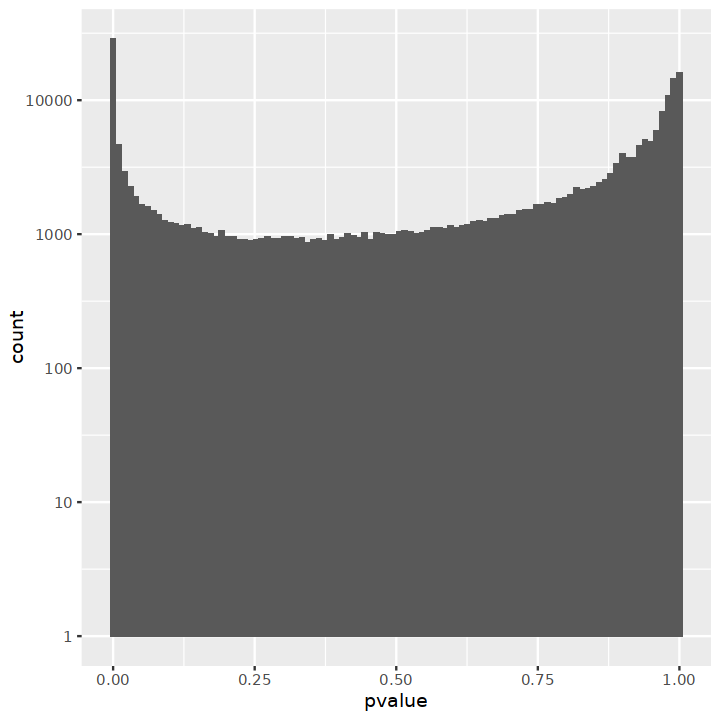

In [229]:
fig.size(6,6)
ggplot(effects, aes(pvalue)) +
geom_histogram(bins = 100) +
scale_y_continuous(trans = 'log10')

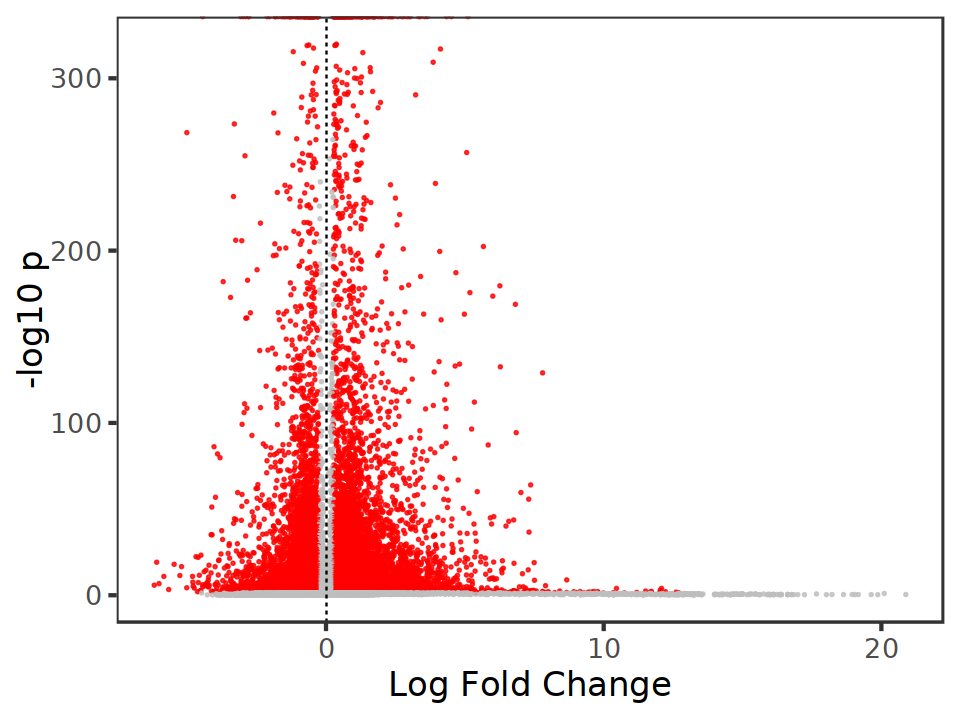

In [230]:
fig.size(6,8)
effects %>% 
        ggplot(aes(logFC, -log10(pvalue), color = pvalue < pval.thresh & abs(logFC) > fc.thresh)) + 
            geom_point(alpha = .8, size = .5) + 
            theme_test(base_size = 20) + 
            geom_vline(xintercept = 0, linetype = 2, color = 'black') + 
            labs(y = '-log10 p', x = 'Log Fold Change') + 
            scale_color_manual(values = c('grey', 'red')) + 
            guides(color = FALSE)

### "Full" - all random with cell.states:tissue interaction term (no CXCR6) 

In [244]:
presto_res1 <- readRDS("/data/brennerlab/Shani/projects/Treg/analysis/integrated/integrated.Tregs.prestoResults.Full.rds")

In [245]:
presto_res1$formula_str

[1] "~"                                                                                                                    
[2] "y"                                                                                                                    
[3] "1 + (1 | orig.ident) + (1 | cell.states:tissue) + (1 | cell.states) + (1 | donorID) + (1 | tissue) + offset(EXPOSURE)"

In [246]:
contrasts_mat = make_contrast.presto(
    presto_res1, 
    var_contrast = 'cell.states')

In [247]:
effects <- contrasts.presto(presto_res1, contrasts_mat, one_tailed = F) %>% 
    dplyr::mutate(cluster = contrast) %>% 
    dplyr::mutate(
        logFC = sign(beta) * log2(exp(abs(beta))), ## convert stats to log2 for interpretability 
        SD = log2(exp(sigma)),
        zscore = logFC / SD
    ) %>%
    arrange(pvalue)

effects$fdr = p.adjust(effects$pvalue, method = 'BH')

In [248]:
#filter genes
pval.thresh <- 0.05
fc.thresh <- log2(1.2)

filtered = effects %>% 
filter(pvalue < pval.thresh & abs(logFC) > fc.thresh) %>% 
group_by(contrast) %>% 
arrange(desc(zscore))%>% ungroup()
filtered %>% head
dim(filtered)


contrast,feature,beta,sigma,zscore,pvalue,cluster,logFC,SD,fdr
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
Proliferating,HMGN2,1.196297,0.1182116,10.119961,4.505935e-24,Proliferating,1.725892,0.1705433,5.748672e-19
ISG high Treg,MX1,2.084549,0.2087079,9.987878,1.722300e-23,ISG high Treg,3.007368,0.3011018,1.464873e-18
ISG high Treg,EIF2AK2,1.649300,0.1680797,9.812603,9.937185e-23,ISG high Treg,2.379437,0.2424878,6.338930e-18
ISG high Treg,ISG15,2.044559,0.2105205,9.711922,2.682309e-22,ISG high Treg,2.949675,0.3037169,1.368836e-17
ISG high Treg,IFIT1,3.275786,0.3495811,9.370604,7.211867e-21,ISG high Treg,4.725960,0.5043389,2.680216e-16
ISG high Treg,MX2,1.798814,0.1922351,9.357366,8.174922e-21,ISG high Treg,2.595140,0.2773366,2.680216e-16


[1] 10125    10

In [249]:
filtered %>% filter(feature == 'AREG')


contrast,feature,beta,sigma,zscore,pvalue,cluster,logFC,SD,fdr
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
AREG Treg,AREG,1.529542,0.6138618,2.491671,0.01271438,AREG Treg,2.206662,0.8856154,0.5078585
Naive Treg - TCF7/CCR7,AREG,1.131422,0.5325500,2.124536,0.03362532,Naive Treg - TCF7/CCR7,1.632297,0.7683072,0.9081115
CD25-high Treg,AREG,-1.227259,0.5341984,-2.297384,0.02159687,CD25-high Treg,-1.770560,0.7706854,0.7059516


In [255]:
filtered %>% filter(feature == 'NR3C1')
filtered %>% filter(feature == 'CXCR6')
effects %>% filter(feature == 'CXCR6')


contrast,feature,beta,sigma,zscore,pvalue,cluster,logFC,SD,fdr
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
AREG Treg,NR3C1,0.2756950,0.09290597,2.967463,0.003002683,AREG Treg,0.3977439,0.1340350,0.1846625
Naive Treg - TCF7/CCR7,NR3C1,-0.2365355,0.09791993,-2.415601,0.015709269,Naive Treg - TCF7/CCR7,-0.3412486,0.1412686,0.5807045


contrast,feature,beta,sigma,zscore,pvalue,cluster,logFC,SD,fdr
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
CD161+ memory Treg,CXCR6,1.049659,0.5247869,2.000162,0.045482782,CD161+ memory Treg,1.514337,0.7571074,0.9999993
Naive Treg - TCF7/CCR7,CXCR6,-3.461145,1.1879185,-2.913622,0.003572623,Naive Treg - TCF7/CCR7,-4.993377,1.7138042,0.2104318


contrast,feature,beta,sigma,zscore,pvalue,cluster,logFC,SD,fdr
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
Naive Treg - TCF7/CCR7,CXCR6,-3.4611454,1.1879185,-2.9136219,0.003572623,Naive Treg - TCF7/CCR7,-4.9933773,1.7138042,0.2104318
CD161+ memory Treg,CXCR6,1.0496588,0.5247869,2.0001619,0.045482782,CD161+ memory Treg,1.5143375,0.7571074,0.9999993
CD25-high CXCR6+ Treg,CXCR6,2.1389118,1.0970729,1.9496534,0.051217448,CD25-high CXCR6+ Treg,3.0857975,1.5827416,0.9999993
CD25-intermediate Treg,CXCR6,-1.6112801,1.0539068,-1.5288640,0.126298173,CD25-intermediate Treg,-2.3245859,1.5204661,0.9999993
AREG Treg,CXCR6,-1.4708035,1.0048921,-1.4636432,0.143291471,AREG Treg,-2.1219209,1.4497529,0.9999993
Proliferating,CXCR6,0.8816701,0.6074277,1.4514816,0.146645804,Proliferating,1.2719810,0.8763329,0.9999993
GZM+ Treg,CXCR6,0.6834325,0.4952602,1.3799464,0.167603150,GZM+ Treg,0.9859846,0.7145094,0.9999993
ISG high Treg,CXCR6,0.4879597,0.4887668,0.9983486,0.318110362,ISG high Treg,0.7039770,0.7051415,0.9999993
CD25-high Treg,CXCR6,0.8243252,0.9658387,0.8534812,0.393392491,CD25-high Treg,1.1892499,1.3934107,0.9999993


In [251]:
show.top <- filtered %>% 
    filter(zscore > 0) %>% 
    group_by(contrast) %>% 
    arrange(contrast, desc(zscore)) %>% 
    dplyr::select(feature, contrast) %>% 
    mutate(row = row_number()) %>% 
    tidyr::pivot_wider(names_from = contrast, values_from = feature)
show.top[1:60,]

row,AREG Treg,CD161+ memory Treg,CD25-high CXCR6+ Treg,CD25-high Treg,CD25-intermediate Treg,GZM+ Treg,ISG high Treg,Naive Treg - TCF7/CCR7,Proliferating,TNFa response Treg
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,NMB,CTSH,CD7,ITM2C,IGKV3-20,IFNG-AS1,MX1,RPS13,HMGN2,HCG18
2,RGS2,AL589693.1,CTLA4,HLA-DPB1,RPL8,GZMK,EIF2AK2,RPS5,PPIA,TUBB4B
3,NR4A2,LAPTM5,LAIR2,HLA-DRA,IGHV2-5,VAMP2,ISG15,EEF1B2,STMN1,DNAJB1
4,PASK,IL6R,TNFRSF4,B2M,SELL,LINC02084,IFIT1,PABPC1,CHCHD2,SELENOK
5,CITED2,GPR25,HCST,MFGE8,RPL35,RERE,MX2,RPS12,DUT,JUND
6,TWIST1,NR1D1,SPOCK2,HLA-DPA1,IL7R,F2R,IRF7,RPL5,ANP32B,TOB1
7,NR3C1,CERK,CD27,HLA-DQB1,RPL26,IFNG,XAF1,RPS8,SLC25A5,TNFAIP3
8,FOS,CMTM6,TIGIT,CPNE2,RPL18A,DLGAP1,SP100,MT-ND4,GAPDH,FAM122C
9,TUBA1A,RARG,HLA-A,HLA-DQA1,RPL29,RIC3,PNPT1,RPS3,HMGB1,IER2


In [252]:
show.top %>% filter(`CD25-high CXCR6+ Treg` == "CXCR6")

row,AREG Treg,CD161+ memory Treg,CD25-high CXCR6+ Treg,CD25-high Treg,CD25-intermediate Treg,GZM+ Treg,ISG high Treg,Naive Treg - TCF7/CCR7,Proliferating,TNFa response Treg
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>


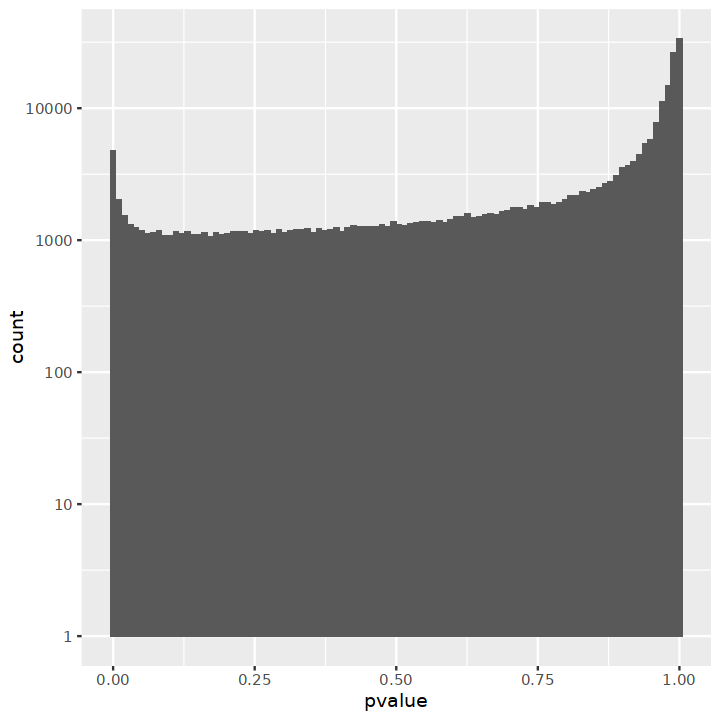

In [253]:
fig.size(6,6)
ggplot(effects, aes(pvalue)) +
geom_histogram(bins = 100) +
scale_y_continuous(trans = 'log10')

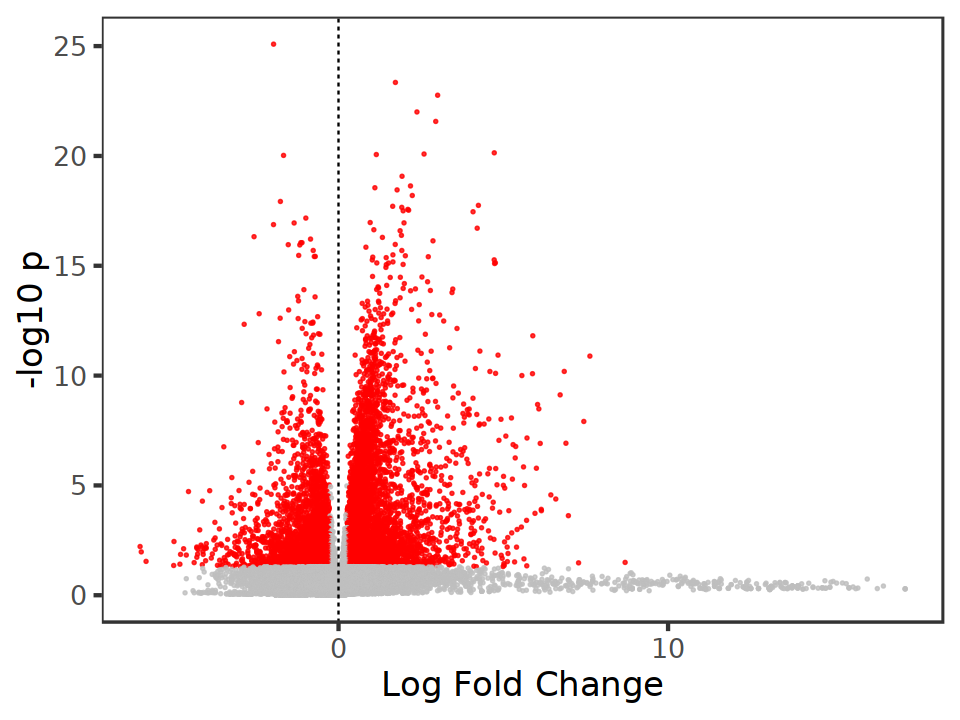

In [254]:
fig.size(6,8)
effects %>% 
        ggplot(aes(logFC, -log10(pvalue), color = pvalue < pval.thresh & abs(logFC) > fc.thresh)) + 
            geom_point(alpha = .8, size = .5) + 
            theme_test(base_size = 20) + 
            geom_vline(xintercept = 0, linetype = 2, color = 'black') + 
            labs(y = '-log10 p', x = 'Log Fold Change') + 
            scale_color_manual(values = c('grey', 'red')) + 
            guides(color = FALSE)

### non regression - Wilcoxon test

In [258]:
de <- FindAllMarkers(merged, test.use = "wilcox")

Calculating cluster Naive Treg

Calculating cluster CD25int Treg

Calculating cluster CD25high Treg

Calculating cluster CD25highCXCR6+ Treg

Calculating cluster AREG+ Treg

Calculating cluster TNFAIP3+ Treg

Calculating cluster CD161+mem. Treg

Calculating cluster ISG Treg

Calculating cluster GZM Treg

Calculating cluster Prolif.



In [270]:
de %>% filter(p_val_adj < 0.05 & avg_log2FC > log2(1.2)) %>% 
    group_by(cluster) %>% 
    arrange(cluster, desc(avg_log2FC)) %>% 
    dplyr::select(gene, cluster) %>% 
    mutate(row = row_number()) %>% 
    tidyr::pivot_wider(names_from = cluster, values_from = gene)

row,Naive Treg,CD25int Treg,CD25high Treg,CD25highCXCR6+ Treg,AREG+ Treg,TNFAIP3+ Treg,CD161+mem. Treg,ISG Treg,GZM Treg,Prolif.
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,APOO,RBFOX2,HLA-DRB5,LAG3,IGKC,CREM,AQP3,ISG15,GZMK,CXCL13
2,PRKCQ-AS1,MT-ATP8,LINC02694,TNFRSF18,FOS,LMNA,KLRB1,IFI6,IFNG-AS1,CCL5
3,GAS5,FP236383.3,HLA-DRB1,MT2A,ZNF331,JUND,GPR25,MT2A,GZMA,STMN1
4,TCF7,AL136456.1,HLA-DPB1,TNFRSF4,FOSB,RGS1,LIMS1,MX1,CCL5,NKG7
5,FP236383.3,RPS10-NUDT3,CD74,MT1E,NR4A2,TNFAIP3,ANXA1,MT1X,LYAR,GZMA
6,MT-ATP8,RPS4Y1,HLA-DPA1,GNLY,AREG,FOSB,CNN2,LY6E,CXCR3,CCL4
7,SNHG29,IFITM1,HPGD,LGALS1,JUND,JUN,NOSIP,MT1E,CNN2,TYMS
8,GIMAP5,PTGER2,IL32,MT1X,RPS10,ZNF331,CCR6,IFIT2,IKZF3,LAG3
9,RBFOX2,APOO,ANXA2,TIMP1,YPEL5,FOS,CD52,XAF1,CST7,TUBA1B


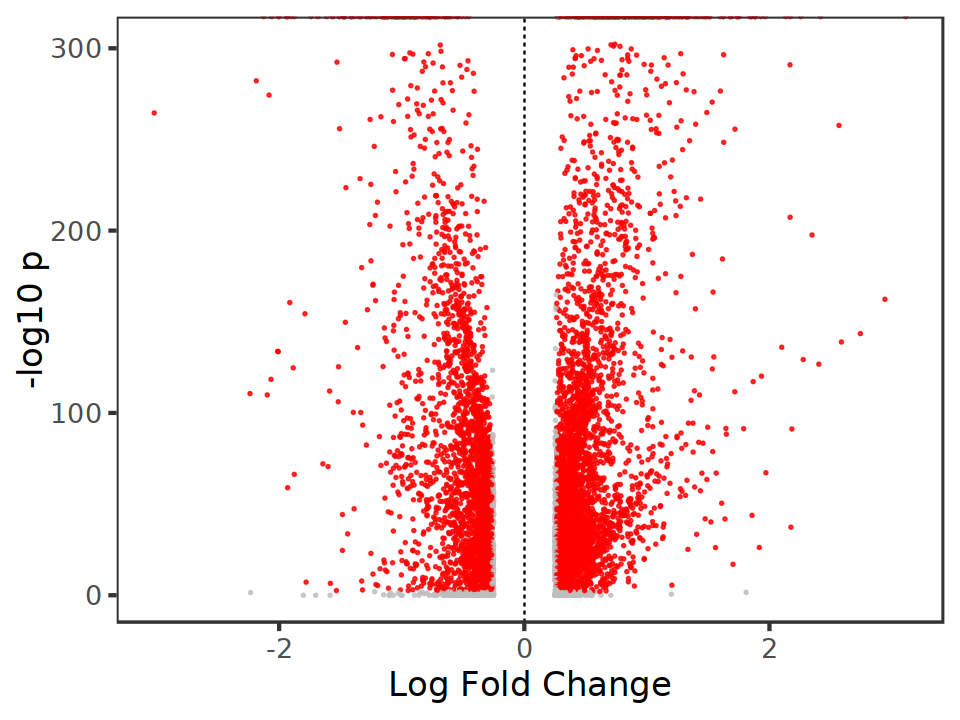

In [274]:
fig.size(6,8)
de %>% 
        ggplot(aes(avg_log2FC, -log10(p_val_adj), color = p_val_adj < 0.01 & abs(avg_log2FC) > log2(1.2))) + 
            geom_point(alpha = .8, size = .5) + 
            theme_test(base_size = 20) + 
            geom_vline(xintercept = 0, linetype = 2, color = 'black') + 
            labs(y = '-log10 p', x = 'Log Fold Change') + 
            scale_color_manual(values = c('grey', 'red')) + 
            guides(color = FALSE)

In [266]:
data.collapsed <- collapse_counts(merged@assays$RNA@counts,
                                  merged@meta.data,
                                  c("cell.states"))

CAREFUL: get_norm makes very strong assumptions about data

